## **Part II: OCR Detection with PaddleOCR**

### **Introduction**

Welcome to Part II of the document processing workflow. If you haven't gone through **Part I**, I highly recommend reviewing it first, as the output from Part I is used here for further processing. In the previous notebook, we focused on **image preprocessing**, **layout recognition**, and **region detection** using Detectron2 and LayoutLMv3, segmenting the document into logical subsections.

### **Why PaddleOCR?**

In this notebook, we leverage **PaddleOCR**, a highly efficient and accurate OCR model. Here's why we chose PaddleOCR:
- **High Accuracy**: PaddleOCR supports advanced text recognition, including multilingual support and fine-grained text extraction.
- **Robustness**: It handles complex layouts and noisy images exceptionally well.
- **Efficiency**: PaddleOCR is optimized for GPU and CPU, ensuring quick processing even for large documents.
- **Customization**: PaddleOCR allows for adjustable parameters such as confidence thresholds and text alignment, providing flexibility to adapt to different document structures.

### **Objective**

Here, we aim to:
1. Use the segmented output from Part I to extract text from specific regions of the document.
2. Demonstrate PaddleOCR's effectiveness in handling structured and unstructured text layouts.

Let’s dive into the OCR detection process using PaddleOCR! :) ( almost done don't worry )


## **Environment Setup**

In [ ]:
!pip install -q paddleocr paddlepaddle
!pip install -q unidecode
!pip install -q pyspellchecker
!pip install -q hunspell
!sudo apt-get install -q hunspell hunspell-fr
!pip install -q language-tool-python
!python -m spacy download fr_core_news_sm
!pip install spacy transformers torch
!pip install -q faiss-gpu
!pip install -q transformers accelerate

# **3. Modeling** - Region-Specific OCR

In [2]:
# Import required libraries for OCR processing and error handling
from PIL import Image, ImageDraw  # For image manipulation and drawing bounding boxes
import pandas as pd  # For creating and managing OCR results in a DataFrame
from paddleocr import PaddleOCR  # OCR model for text detection and recognition
import os  # For handling file and directory paths
import traceback  # For detailed error reporting

# Function to run PaddleOCR on an image
def paddle_inference(img_path, lang='en'):
    # Initialize PaddleOCR with GPU support and language-specific configuration
    ocr = PaddleOCR(use_gpu=True, use_angle_cls=True, lang=lang, min_subgraph_size=10)

    # Perform OCR on the image and obtain results
    ocr_result = ocr.ocr(img_path, cls=True)

    # Extract and structure OCR results into a list of dictionaries
    results = []
    for line in ocr_result:
        for boxes, txt_info in line:
            if len(txt_info) == 2:  # Ensure the result contains text and confidence
                text, confidence = txt_info
                results.append({
                    'coordinates': boxes,  # Bounding box coordinates
                    'text': text,  # Detected text
                    'confidence': confidence  # Confidence score
                })

    # Handle cases where no text is detected
    if not results:
        print("No text detected.")
        return None, None

    # Annotate the image with bounding boxes around detected text
    image = Image.open(img_path).convert('RGB')
    draw = ImageDraw.Draw(image)

    for res in results:
        # Convert bounding box coordinates for visualization
        coordinates = [pt for box in res['coordinates'] for pt in box]
        draw.polygon(coordinates, outline='red')

    # Save the annotated image with a modified filename
    base_filename = os.path.splitext(os.path.basename(img_path))[0]
    result_path = f'results/{base_filename}_result.jpg'
    image.save(result_path)

    # Convert results into a pandas DataFrame for further processing
    df = pd.DataFrame(results)

    return result_path, df

# Function to consolidate OCR results into a summary DataFrame
def consolidate_ocr_results(filename, ocr_df):
    # Ensure confidence scores are numeric for filtering
    ocr_df['confidence'] = pd.to_numeric(ocr_df['confidence'], errors='coerce')

    # Filter results with confidence scores above a threshold
    filtered_df = ocr_df[ocr_df['confidence'] > 0.2]

    # Combine all detected text into a single string
    all_text = ' '.join(filtered_df['text'])

    # Combine confidence scores into a single string
    all_scores = ' '.join([str(score) for score in filtered_df['confidence']])

    # Create a summary DataFrame with combined results
    result_df = pd.DataFrame({
        'Filename': [filename],
        'OCR_Text': [all_text],
        'Scores': [all_scores]
    })

    return result_df

# Function to process a folder of images and extract OCR results
def process_folder(folder_path, lang='fr'):
    # Identify supported image files in the folder
    supported_extensions = ('.png', '.jpg', '.jpeg', '.bmp', '.gif', '.tiff')
    files = [f for f in os.listdir(folder_path) if f.lower().endswith(supported_extensions)]

    # Initialize a list to store consolidated OCR results
    results_dfs = []

    # Loop through each file and process with PaddleOCR
    for file in files:
        file_path = os.path.join(folder_path, file)
        try:
            # Run PaddleOCR inference and retrieve results
            result_image_path, ocr_dataframe = paddle_inference(file_path, lang)
            if ocr_dataframe is not None:
                # Consolidate results for each file into a summary DataFrame
                consolidated_df = consolidate_ocr_results(file, ocr_dataframe)
                results_dfs.append(consolidated_df)
        except Exception as e:
            # Log any errors encountered during processing
            error_message = f"An error occurred while processing {file}: {e}\n{traceback.format_exc()}\n"
            print(error_message)
            with open(os.path.join(folder_path, 'errors.txt'), 'a') as error_file:
                error_file.write(error_message)

    # Combine all results into a single DataFrame
    all_results_df = pd.concat(results_dfs, ignore_index=True) if results_dfs else pd.DataFrame()

    return all_results_df  # Return the consolidated results


### **Preparing input and output locations**

In [ ]:
# make a folder to put the annotated images with bounding boxes
!mkdir results

# upload the cropped sections images zip file (from part I), then unzip it
!unzip /content/cropped_sections.zip -d images


### **Model Inference**

In [4]:
# do the ocr!
folder_path = '/content/images/cropped_sections'
lang = 'fr'

# Process the folder and get the dataframe with results
all_ocr_results = process_folder(folder_path)
all_ocr_results.to_csv("images-output.csv")
print(all_ocr_results)

download https://paddleocr.bj.bcebos.com/PP-OCRv3/english/en_PP-OCRv3_det_infer.tar to /root/.paddleocr/whl/det/en/en_PP-OCRv3_det_infer/en_PP-OCRv3_det_infer.tar


100%|██████████| 3910/3910 [00:01<00:00, 1958.16it/s]


download https://paddleocr.bj.bcebos.com/PP-OCRv3/multilingual/latin_PP-OCRv3_rec_infer.tar to /root/.paddleocr/whl/rec/latin/latin_PP-OCRv3_rec_infer/latin_PP-OCRv3_rec_infer.tar


100%|██████████| 9930/9930 [00:19<00:00, 518.54it/s] 


download https://paddleocr.bj.bcebos.com/dygraph_v2.0/ch/ch_ppocr_mobile_v2.0_cls_infer.tar to /root/.paddleocr/whl/cls/ch_ppocr_mobile_v2.0_cls_infer/ch_ppocr_mobile_v2.0_cls_infer.tar


100%|██████████| 2138/2138 [00:15<00:00, 139.04it/s]

[2024/12/02 10:24:09] ppocr DEBUG: Namespace(help='==SUPPRESS==', use_gpu=False, use_xpu=False, use_npu=False, use_mlu=False, ir_optim=True, use_tensorrt=False, min_subgraph_size=10, precision='fp32', gpu_mem=500, gpu_id=0, image_dir=None, page_num=0, det_algorithm='DB', det_model_dir='/root/.paddleocr/whl/det/en/en_PP-OCRv3_det_infer', det_limit_side_len=960, det_limit_type='max', det_box_type='quad', det_db_thresh=0.3, det_db_box_thresh=0.6, det_db_unclip_ratio=1.5, max_batch_size=10, use_dilation=False, det_db_score_mode='fast', det_east_score_thresh=0.8, det_east_cover_thresh=0.1, det_east_nms_thresh=0.2, det_sast_score_thresh=0.5, det_sast_nms_thresh=0.2, det_pse_thresh=0, det_pse_box_thresh=0.85, det_pse_min_area=16, det_pse_scale=1, scales=[8, 16, 32], alpha=1.0, beta=1.0, fourier_degree=5, rec_algorithm='SVTR_LCNet', rec_model_dir='/root/.paddleocr/whl/rec/latin/latin_PP-OCRv3_rec_infer', rec_image_inverse=True, rec_image_shape='3, 48, 320', rec_batch_num=6, max_text_length=25,

[2024/12/02 10:24:10] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.37385034561157227
[2024/12/02 10:24:10] ppocr DEBUG: cls num  : 3, elapsed : 0.04217863082885742
[2024/12/02 10:24:11] ppocr DEBUG: rec_res num  : 3, elapsed : 0.16911768913269043
[2024/12/02 10:24:11] ppocr DEBUG: Namespace(help='==SUPPRESS==', use_gpu=False, use_xpu=False, use_npu=False, use_mlu=False, ir_optim=True, use_tensorrt=False, min_subgraph_size=10, precision='fp32', gpu_mem=500, gpu_id=0, image_dir=None, page_num=0, det_algorithm='DB', det_model_dir='/root/.paddleocr/whl/det/en/en_PP-OCRv3_det_infer', det_limit_side_len=960, det_limit_type='max', det_box_type='quad', det_db_thresh=0.3, det_db_box_thresh=0.6, det_db_unclip_ratio=1.5, max_batch_size=10, use_dilation=False, det_db_score_mode='fast', det_east_score_thresh=0.8, det_east_cover_thresh=0.1, det_east_nms_thresh=0.2, det_sast_score_thresh=0.5, det_sast_nms_thresh=0.2, det_pse_thresh=0, det_pse_box_thresh=0.85, det_pse_min_area=16, det_pse_scale=1, scale

# **OCR results (Overview and Description)**


In [ ]:
#download results and output
from google.colab import files
!zip -r results.zip *"result"*
files.download('results.zip')
files.download('images-output.csv')

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
# Load the CSV file
csv_path = "/content/images-output.csv"  # Update with your CSV path
data = pd.read_csv(csv_path)
# Display the first few rows
data.head()


,Unnamed: 0,Filename,OCR_Text,Scores
0,0,Title.png,RECEPISSE DE DEPOT DE PLAINTE,0.9964414238929749 0.998379111289978 0.9925673...
1,1,footer.png,Pour le: procureur de la République L'Agent de...,0.9688677191734314 0.9957493543624878 0.973791...
2,2,Advice.png,Conservez précieusement cette lettre. Elle con...,0.996211051940918 0.9837509989738464 0.9451836...
3,3,main.png,"Madame, monsieur, Vous venez de déposer une pl...",0.983346164226532 0.9877041578292847 0.9699826...
4,4,header_general_info.png,Date du dépt de plainte 21/03/2015 Identité d...,0.994041383266449 0.9982107281684875 0.9791837...


### **CSV Overview and Description**

This CSV file contains the OCR output from PaddleOCR, structured as follows:

#### **Columns Explanation**
1. **`Unnamed: 0`**: A numerical index automatically added during the CSV creation. It can be ignored for analysis as it replicates the row numbering.
2. **`Filename`**: The name of the image file corresponding to the detected text region, such as `Title.png` or `footer.png`. This indicates which subsection of the document the OCR was applied to.
3. **`OCR_Text`**: The text detected by PaddleOCR for each image. This contains the extracted content from the specific region, like titles, main text, or footer information.
4. **`Scores`**: Confidence scores for the detected text. Each score corresponds to the OCR's confidence in recognizing individual words or tokens within the `OCR_Text`.

#### **Sample Observations**
- **Row 0 (Title)**: The OCR accurately captured the title "RECEPISSE DE DEPOT DE PLAINTE" with high confidence scores.
- **Row 1 (Footer)**: Text from the footer, including "procureur de la République," was detected with confidence values listed in `Scores`.
- **Row 2 (Advice)**: The advice section includes instructions for preserving the document, with a mix of confidence scores.
- **Row 3 (Main Content)**: Contains the body of the document, addressing "Madame, monsieur," and detailing the deposition process. The confidence values indicate high OCR accuracy.
- **Row 4 (Header General Info)**: Captures metadata like the date of deposition ("21/03/2015") and identity details, also with strong confidence scores.

#### **Key Points**
- The CSV provides both textual content (`OCR_Text`) and quality indicators (`Scores`) for further analysis.
- Each row corresponds to a specific subsection of the document (e.g., Title, Main Content, Advice).
- High confidence values suggest that PaddleOCR performed well, but further inspection of text accuracy is recommended.



### **Visualization of the OCR Results**
In the CSV file, the Scores column contains multiple confidence values because PaddleOCR outputs a confidence score for each detected token (word or small text segment). These scores represent how confident the OCR model is about correctly identifying each token.

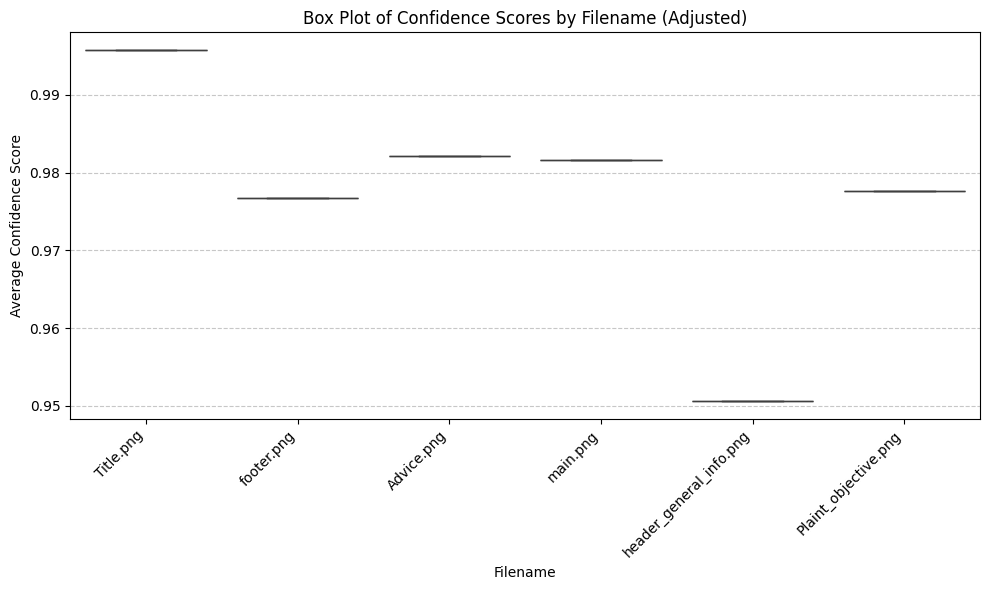

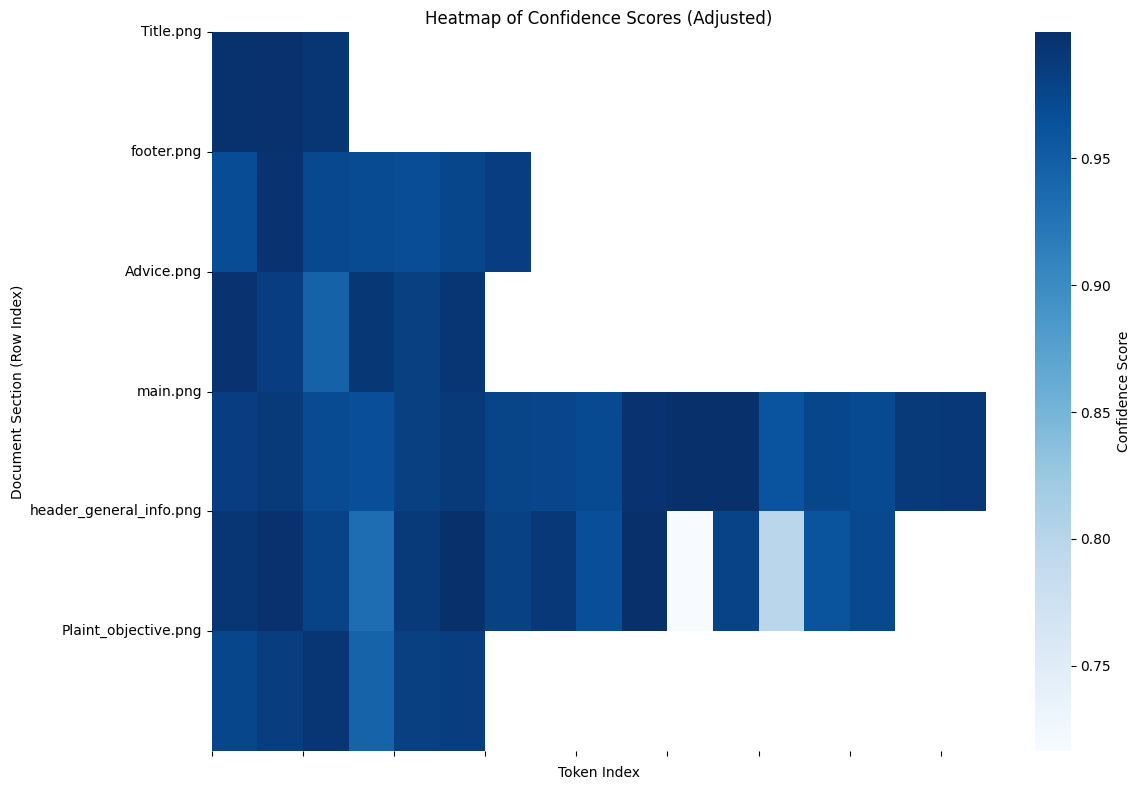

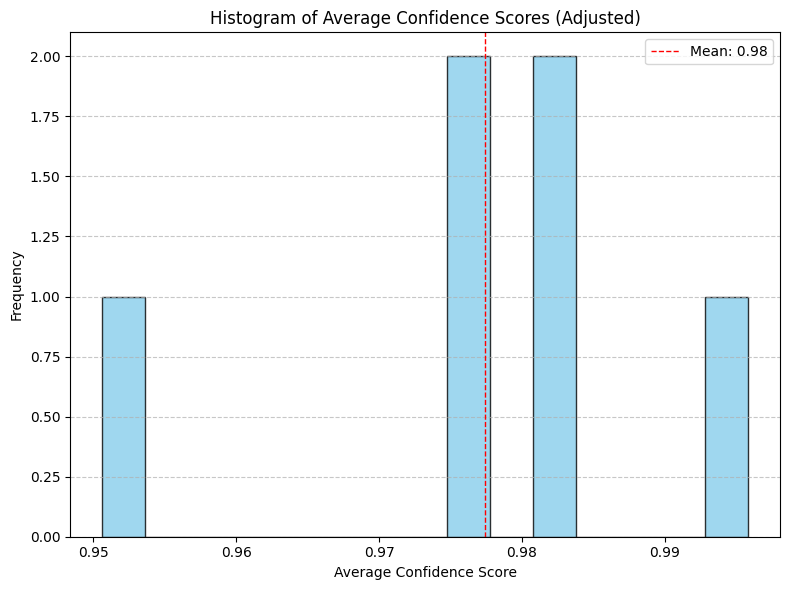

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Load the CSV file
csv_path = "/content/images-output.csv"  # Update with your CSV path
data = pd.read_csv(csv_path)

# Preprocess the Scores column
data['Scores'] = data['Scores'].apply(lambda x: [float(num) for num in x.split()])

# --- Adjusted Box Plot ---
def plot_boxplot(data):
    """
    Box Plot: Shows the distribution of confidence scores by file with better granularity.
    """
    # Compute average scores directly from the list in the 'Scores' column
    data['Avg_Score'] = data['Scores'].apply(np.mean)
    plt.figure(figsize=(10, 6))
    sns.boxplot(x="Filename", y="Avg_Score", data=data)
    plt.xticks(rotation=45, ha='right')
    plt.ylabel("Average Confidence Score")
    plt.xlabel("Filename")
    plt.title("Box Plot of Confidence Scores by Filename (Adjusted)")
    plt.grid(axis="y", linestyle="--", alpha=0.7)
    plt.tight_layout()
    plt.show()

# --- Adjusted Heatmap ---
def plot_heatmap(data):
    """
    Heatmap: Displays confidence scores for each token by document section.
    """
    # Transform the Scores column (list) into a matrix for the heatmap
    max_length = max(len(row) for row in data["Scores"])  # Determine the maximum number of tokens
    score_matrix = np.array([np.pad(row, (0, max_length - len(row)), constant_values=np.nan) for row in data["Scores"]])
    plt.figure(figsize=(12, 8))
    sns.heatmap(score_matrix, cmap="Blues", annot=False, cbar_kws={"label": "Confidence Score"})
    plt.title("Heatmap of Confidence Scores (Adjusted)")
    plt.xlabel("Token Index")
    plt.ylabel("Document Section (Row Index)")
    plt.xticks(np.arange(0, max_length, 2), rotation=45)
    plt.yticks(np.arange(len(data)), data["Filename"], rotation=0)
    plt.tight_layout()
    plt.show()

# --- Adjusted Histogram ---
def plot_histogram(data):
    """
    Histogram: Shows the distribution of average confidence scores with more details.
    """
    avg_scores = data['Scores'].apply(np.mean)
    plt.figure(figsize=(8, 6))
    plt.hist(avg_scores, bins=15, color="skyblue", edgecolor="black", alpha=0.8)
    plt.axvline(np.mean(avg_scores), color="red", linestyle="dashed", linewidth=1, label=f"Mean: {np.mean(avg_scores):.2f}")
    plt.xlabel("Average Confidence Score")
    plt.ylabel("Frequency")
    plt.title("Histogram of Average Confidence Scores (Adjusted)")
    plt.legend()
    plt.grid(axis="y", linestyle="--", alpha=0.7)
    plt.tight_layout()
    plt.show()

# --- Run All Visualizations ---
plot_boxplot(data)
plot_heatmap(data)
plot_histogram(data)


### **Analysis of the Plots**

#### **1. Box Plot of Confidence Scores by Filename**
- **What it shows:** This box plot visualizes the distribution of average confidence scores for each document section. The y-axis represents the confidence scores, and the x-axis represents the filenames corresponding to sections of the document.
- **Observations:**
  - The plot highlights subtle differences in average confidence scores across different sections.
  - Most sections exhibit high confidence scores near 0.98, with minimal variation.
  - The `footer.png` section shows slightly lower confidence scores compared to others. (Maybe due to the existence of the signature)

#### **2. Heatmap of Confidence Scores**
- **What it shows:** This heatmap represents token-level confidence scores for each section of the document. Rows correspond to document sections, and columns correspond to individual tokens in the OCR output.
- **Observations:**
  - The heatmap reveals token-specific confidence scores, with darker colors indicating higher confidence.
  - Some sections, such as `main.png` and `Advice.png`, exhibit more uniform confidence scores, suggesting consistent OCR performance.
  - Lighter shades in certain areas indicate regions where OCR struggled, potentially due to noise or document quality.

#### **3. Histogram of Average Confidence Scores**
- **What it shows:** This histogram illustrates the frequency distribution of average confidence scores across all document sections.
- **Observations:**
  - The majority of document sections fall into the high-confidence range (0.97-0.98).
  - A few sections, like `footer.png`, contribute to the lower confidence range (~0.95). (Maybe due to the existence of the signature)
  - This distribution confirms that PaddleOCR achieved consistently high confidence for most tokens.

### **Conclusion**
- Overall, the results demonstrate that PaddleOCR performed reliably across most sections, with only minor inconsistencies requiring attention.


### **Analysis of OCR Output and Preprocessing Steps**

#### **Challenges Identified**
1. **Missing Words:**
   - Certain parts of the document were not captured or were incomplete (e.g., "préuve" detected as "préuve.de").
   - Structured fields like dates and names were partially missed.

2. **Incorrect Words:**
   - Misinterpretation of words due to OCR limitations, such as:
     - "BEAuVAlS" instead of "BEAUVAIS."
     - "enguéte" instead of "enquête."
   - Random capitalization and misplaced special characters (e.g., "I'Oise" instead of "l'Oise").

3. **Unnecessary Punctuation:**
   - Extra or misplaced punctuation causing clutter (e.g., "attente au patrimoine d'autrui." output as "attente.au patrimoine d'autrui.").

4. **Line Breaks and Formatting Issues:**
   - Arbitrary line breaks disrupting the logical flow of text.

5. **Signature and Stamp Challenges:**
   - OCR struggles with handwritten or stamped areas, leading to nonsensical outputs.

---

#### **Solution: Preprocessing Steps**
1. **Image Preprocessing:**
   - **Binarization:** Adaptive thresholding to enhance text clarity.
   - **Denoising:** Apply Gaussian or median blur to reduce noise, especially around stamps.
   - **Contrast Adjustment:** Histogram equalization for better text visibility.

2. **Text Structuring:**
   - Merge broken lines and remove extraneous punctuation.
   - Group text logically based on detected regions (e.g., headers, body, footer).

3. **Language-Specific Adjustments:**
   - Ensure proper handling of French accents and special characters by fine-tuning OCR parameters.

4. **Custom Rules for Known Fields:**
   - Use regular expressions to detect patterns like dates and names.
   - Apply uppercase checks for headers and titles.

5. **Handle Problematic Areas:**
   - Exclude handwritten signatures or stamped sections using predefined bounding boxes.


# **4. Post-OCR Text Processing Pipeline**

> Ajouter une citation



## **1. Text Cleaning and Normalization**
This step standardizes and organizes the extracted text:
- Adjusts headers to uppercase or sentence case as needed.
- Normalizes text to ensure consistent encoding while retaining accents.
- Preserves French contractions.
- Removes extra spaces and merges broken lines.
- Groups text by subsections for logical organization.

**Output**: `/content/cleaned_text.txt`

In [9]:
import pandas as pd
import re
from spellchecker import SpellChecker
import unicodedata

# --- Step 1: Header Correction ---
def correct_headers(text):
    """
    Adjusts headers to uppercase format.
    """
    lines = text.split("\n")
    corrected_lines = [line.upper() if line.isupper() else line for line in lines]
    return "\n".join(corrected_lines)

# --- Step 2: Sentence Case Correction ---
def correct_sentence_case(text):
    """
    Converts text to sentence case.
    """
    sentences = re.split(r'(?<=[.!?])\s+', text)
    corrected_text = " ".join(sentence.capitalize() for sentence in sentences)
    return corrected_text

# --- Step 3: Normalization ---
def normalize_text(text):
    """
    Normalize text to ensure consistent encoding while retaining accents.
    """
    return unicodedata.normalize("NFKC", text)

# --- Step 4: Preserve French Contractions ---
def correct_french_contractions(text):
    """
    Corrects common French-specific OCR errors and preserves contractions.
    """
    text = re.sub(r"(\b[dDlL]'|\bqu')(\s+)", r"\1", text)  # Remove spaces after contractions
    return text

# --- Step 6: Remove Extra Spaces ---
def remove_extra_spaces(text):
    """
    Removes unnecessary spaces.
    """
    return re.sub(r"\s+", " ", text).strip()

# --- Step 7: Merge Broken Lines ---
def merge_broken_lines(text):
    """
    Merges broken lines for better sentence flow.
    """
    lines = text.split("\n")
    merged_text = ""
    for i, line in enumerate(lines):
        if line.endswith(".") or i == len(lines) - 1:  # End of a sentence
            merged_text += line.strip() + " "
        else:
            merged_text += line.strip() + " "
    return merged_text.strip()

# --- Step 8: Group by Subsection ---
def group_by_subsection(df):
    """
    Group text by logical subsections based on the CSV.
    """
    grouped_text = {}
    for index, row in df.iterrows():
        subsection_name = row['Filename'].replace('.png', '').capitalize()
        grouped_text[subsection_name] = row['OCR_Text']
    return grouped_text

# --- Full Preprocessing Pipeline ---
def preprocess_csv(file_path):
    """
    Complete preprocessing pipeline for OCR CSV output.
    """
    # Load CSV
    df = pd.read_csv(file_path)

    # Apply general cleaning steps
    df['OCR_Text'] = df['OCR_Text'].apply(correct_headers)
    df['OCR_Text'] = df['OCR_Text'].apply(correct_sentence_case)
    df['OCR_Text'] = df['OCR_Text'].apply(normalize_text)
    df['OCR_Text'] = df['OCR_Text'].apply(correct_french_contractions)
    df['OCR_Text'] = df['OCR_Text'].apply(remove_extra_spaces)
    df['OCR_Text'] = df['OCR_Text'].apply(merge_broken_lines)

    # Group by subsections
    grouped_text = group_by_subsection(df)

    return df, grouped_text

# --- Save Cleaned Text to File ---
def save_cleaned_text(grouped_text, output_file):
    """
    Save cleaned text to a .txt file.
    """
    with open(output_file, 'w', encoding='utf-8') as f:
        for section, text in grouped_text.items():
            f.write(f"### {section}\n")
            f.write(f"{text}\n\n")

# --- Run Preprocessing ---
csv_path = "/content/images-output.csv"  # Update with your file path
output_file = "/content/cleaned_text.txt"

# Execute pipeline
processed_df, grouped_sections = preprocess_csv(csv_path)

# Save to file
save_cleaned_text(grouped_sections, output_file)

# Display a preview
print(f"Cleaned text saved to {output_file}")


Cleaned text saved to /content/cleaned_text.txt


## **2. Noise Removal and Error Correction**
Refines the text by addressing common OCR errors:
- Removes extraneous or incorrect punctuation and spaces.
- Corrects general OCR misinterpretations (e.g., `i` misread as `L`).
- Formats numerical values in French style (e.g., `1 000,00`).

**Output**: `/content/enhanced_cleaned_output.txt`

In [10]:
import re


# --- General Cleaning Function ---
def general_cleaning(text):
    """
    Apply additional cleaning for already cleaned sections.
    - Focus on polishing remaining OCR-specific issues.
    - Preserve French accents and proper sentence case.
    """
    # Normalize spaces and punctuation
    text = re.sub(r"\s+", " ", text)  # Normalize spaces
    text = re.sub(r"\.{2,}", ".", text)  # Replace multiple dots with a single dot

    # Correct OCR-specific errors
    corrections = {
        "depot": "dépôt",
        "dépot": "dépôt",
        "daux": "deux",
        "3q.000": "30,000",
        ".1.5.0o euros": "15,000 euros",
        "45.0o0":"45,000",
        "ros": "nos",
        "beauvals": "Beauvais",
        "mauvais": "Beauvais",
        "dépt": "dépôt",
        "téi.": "Tél.",
        "(lnsee:60256": "(INSEE: 60256)",
        "m. le": "M. le",
        "ies": "les",
        "ä": "à",
        "noyen": "moyen",
        "préuve.de": "preuve de",
        "aupres": "auprès",
        "precieusement": "précieusement",
        "Ces.peines": "Ces peines",
        "enguète.de": "enquête de",
        ".et": "et",
        "tiendra.": "tiendra",
        "gendarme florian laugenie": "Gendarme Florian Laugenie",
        "emprisonnerent": "emprisonnement",
        "emprisonnerentet": "emprisonnement et",
        "meru cob auneutl bt auneuil": "Méru COB Auneuil BT Auneuil",
        "Recepisse": "Récépissé",
        "eunos": "euros",
        "donnees": "données",
        "l'identite": "l'identité",
        "républigue": "république",
        "quicongue": "quiconque",
        ".tenté:": "tenté",
        "faire.": "faire",
        ".que": "que",
        "soit,.": "soit,",
        "peines:": "peines",
        "infraction.est": "infraction est",
        "enguéte.de": "enquête de",
        "fresneaux-montchevreu1l": "fresneaux-montchevreuil",
        " i ":" il ",
        "ilnformatilons":"informations",
        ",:":",",
        "les:":"les",
        "informations.": "informations",
        "les.droits": "les droits",
        "des:victimes" : "des victimes",
        "groupement.de": "groupement de",
    }
    for error, fix in corrections.items():
        text = re.sub(re.escape(error), fix, text)

    # Fix sentence case
    sentences = re.split(r"(?<!\w\.\w.)(?<![A-Z][a-z]\.)(?<=\.|\?)\s", text)
    text = " ".join(sentence.capitalize() for sentence in sentences)

    # Remove unwanted characters and fix punctuation
    text = text.replace("< ", "\"").replace(" >", "\"")  # Replaces all < and > with "
    text = text.replace("i'", "l'")  # Replace occurrences of "i'" with "l'"
    text = text.replace(';', ',')

    return text

# --- Process and Save ---
def preprocess_text_file(input_file, output_file):
    """
    Preprocess an already cleaned text file and save the enhanced output.
    """
    # Read the input file
    with open(input_file, "r", encoding="utf-8") as file:
        lines = file.readlines()

    # Process each section and clean
    processed_sections = []
    current_section = ""
    current_text = []
    for line in lines:
        if line.startswith("###"):
            # Save the current section before starting a new one
            if current_section:
                processed_text = general_cleaning("\n".join(current_text))
                processed_sections.append(f"### {current_section}\n{processed_text}\n")
            current_section = line.strip("### \n")  # Extract section name
            current_text = []
        else:
            current_text.append(line.strip())  # Accumulate text for the section

    # Handle the last section
    if current_section:
        processed_text = general_cleaning("\n".join(current_text))
        processed_sections.append(f"### {current_section}\n{processed_text}\n")

    # Merge all processed sections and save to a file
    merged_output = "\n\n".join(processed_sections)
    with open(output_file, "w", encoding="utf-8") as file:
        file.write(merged_output)

    print(f"Enhanced text saved to {output_file}.")

# --- File Paths ---
input_txt_path = "/content/cleaned_text.txt"  # Path to the cleaned input text file
output_txt_path = "/content/enhanced_cleaned_output.txt"  # Path for the enhanced output file

# --- Run Processing ---
preprocess_text_file(input_txt_path, output_txt_path)


Enhanced text saved to /content/enhanced_cleaned_output.txt.


## **3. Structural Updates**
Improves the document's general structure for better clarity:
- Adds or refines section titles.
- Ensures consistent formatting across sections.

**Output**: `/content/updated_structure.txt`

In [11]:
def update_section_titles(input_file_path, output_file_path):
    """
    Updates section titles in a text file to their French equivalents.

    Args:
        input_file_path (str): Path to the input text file.
        output_file_path (str): Path to save the updated text file.
    """
    # Define a mapping for section title replacements
    title_replacements = {
        "### Title": "### Titre de la lettre:",
        "### Footer": "### Pieds de page (Informations et Références Légales et Sanctions):",
        "### Advice": "### Conseils (Conservation de ce Document):",
        "### Main": "### Contenu Principal de la lettre (Informations sur la Plainte et Droits des Victimes):",
        "### Header_general_info": "### Informations Générales sur le Dépôt de Plainte:",
        "### Plaint_objective": "### Objet de la Plainte:",
    }

    try:
        # Read the input file
        with open(input_file_path, "r", encoding="utf-8") as file:
            text = file.read()

        # Replace section titles
        for original_title, updated_title in title_replacements.items():
            text = text.replace(original_title, updated_title)

        # Write the updated text to the output file
        with open(output_file_path, "w", encoding="utf-8") as file:
            file.write(text)

        print(f"Updated section titles saved to {output_file_path}.")

    except Exception as e:
        print(f"An error occurred: {e}")

# Example Usage
input_file = "/content/enhanced_cleaned_output.txt"  # Replace with the path to the input text file
output_file = "/content/updated_structure.txt"  # Replace with the path to save the updated text file

# Update the section titles and save the output
update_section_titles(input_file, output_file)


Updated section titles saved to /content/updated_structure.txt.


## **4. French Spell Checking**
Applies a spell-checking step using **Hunspell**, enhanced with custom functions to preserve document-specific characteristics:
- **Why Hunspell?**: It provides robust support for French linguistic rules, including contractions and accent marks.
- Customizations ensure the integrity of legal terminologies and document-specific text.

**Output**: `/content/spell_check.txt`

In [12]:
import re
import subprocess

def correct_spelling_with_hunspell(input_file_path, output_file_path, custom_words=None):
    """
    Correct spelling using the system-installed Hunspell via subprocess, with specific corrections.
    Args:
        input_file_path (str): Path to the input text file.
        output_file_path (str): Path to save the corrected text file.
        custom_words (list): List of custom words to be ignored by the spell checker.
    """

    def protect_entities(text):
        """
        Protect valid entities using non-linguistic markers like @@PLACEHOLDER@@ to prevent Hunspell from altering them.
        """
        text = re.sub(r'\((france)\)', r'@@FRANCE@@', text, flags=re.IGNORECASE) # Match variations of (insee: 60256)
        text = re.sub(r'\((insee[:\s]*\d+)\)', r'@@INSEE@@', text, flags=re.IGNORECASE)
        text = re.sub(r'\b(laugenie)\b', r'@@LAUGENIE@@', text, flags=re.IGNORECASE)
        text = re.sub(r'\b(guiet)\b', r'@@GUIET@@', text, flags=re.IGNORECASE)
        text = re.sub(r'\b(auneuil)\b', r'@@AUNEUIL@@', text, flags=re.IGNORECASE)
        return text

    def restore_entities(text):
        """
        Restore protected entities by replacing markers with their original values.
        """
        text = text.replace('@@FRANCE@@', '(France)')
        text = text.replace('@@INSEE@@', '(INSEE 60256)')
        text = text.replace('@@LAUGENIE@@', 'Laugenie')
        text = text.replace('@@GUIET@@', 'Guiet')
        text = text.replace('@@AUNEUIL@@', 'Auneuil')
        return text

    def add_custom_words(custom_words):
        """
        Add custom words to Hunspell via a personal word list.
        """
        if custom_words:
            with open("custom_words.dic", "w", encoding="utf-8") as file:
                for word in custom_words:
                    file.write(word + "\n")
            return ["-p", "custom_words.dic"]
        return []

    try:
        # Read input text file
        with open(input_file_path, 'r', encoding='utf-8') as file:
            lines = file.readlines()

        corrected_lines = []
        for line in lines:
            # Protect entities before spell-checking
            protected_line = protect_entities(line)

            words = protected_line.split()
            corrected_line = []
            for word in words:
                # Skip spell-checking for protected placeholders
                if word.startswith("@@") and word.endswith("@@"):
                    corrected_word = word  # Skip correction for placeholders
                else:
                    # Use Hunspell CLI to check and suggest corrections
                    process = subprocess.run(
                        ['hunspell', '-d', 'fr_FR'] + add_custom_words(custom_words),
                        input=word,
                        text=True,
                        stdout=subprocess.PIPE,
                        stderr=subprocess.PIPE
                    )
                    suggestions = process.stdout.splitlines()
                    # If corrections are available, pick the first suggestion
                    if len(suggestions) > 1 and suggestions[1].startswith('&'):
                        corrected_word = suggestions[1].split(':')[-1].split(',')[0].strip()
                    else:
                        corrected_word = word
                corrected_line.append(corrected_word)

            # Reassemble the line
            corrected_lines.append(" ".join(corrected_line))

        # Restore protected entities after spell-checking
        restored_text = "\n".join([restore_entities(line) for line in corrected_lines])

        # Write corrected text to output file
        with open(output_file_path, 'w', encoding='utf-8') as file:
            file.write(restored_text)

        print(f"Spelling correction completed. Corrected text saved to: {output_file_path}")

    except Exception as e:
        print(f"An error occurred: {e}")

# Example Usage
custom_words = ["l'article", "ci-dessus", "si", "l'oise", "ce qui", "l'Oise", "mieux", "cette", "si cette", "Laugenie", "laugenie", "Guiet", "guiet", "Auneuil", "auneuil", "l'article 441-9"]
input_file = "/content/updated_structure.txt"  # Replace with your input file path
output_file = "/content/spell_check.txt"  # Replace with your output file path
correct_spelling_with_hunspell(input_file, output_file, custom_words)


Spelling correction completed. Corrected text saved to: /content/spell_check.txt


# **5. Testing POS Tagging & NER for Structured Data Extraction**

In [14]:
import re
import json
import numpy as np
from transformers import AutoTokenizer, AutoModelForTokenClassification, pipeline

# --- Step 1: Load and Preprocess Text ---
def load_and_preprocess_text(file_path):
    """
    Load text from a file and normalize spacing.
    """
    with open(file_path, "r", encoding="utf-8") as file:
        text = file.read()
    # Normalize spaces
    text = re.sub(r"\s+", " ", text).strip()
    return text

# --- Step 2: Split Text into Sections ---
def split_into_sections(text):
    """
    Split text into sections using '###' as a delimiter.
    """
    sections = {}
    # Match sections starting with ### and capture their content
    matches = re.finditer(r"###\s*(.*?)(?=###|$)", text, re.DOTALL)
    for match in matches:
        section_text = match.group(1).strip()
        # Split section into title and content
        if ":" in section_text:
            section_name, section_content = section_text.split(":", 1)
            sections[section_name.strip()] = section_content.strip()
    return sections

# --- Step 3: Run NER for Each Section ---
def run_ner_on_section(section_name, section_content, ner_pipeline):
    """
    Process a single section with NER and return the results.
    """
    print(f"Processing section: {section_name}")
    print(f"Content preview: {section_content[:200]}...")  # Debugging: Check the input content
    try:
        ner_results = ner_pipeline(section_content)
        return {"content": section_content, "entities": ner_results}
    except Exception as e:
        print(f"Error processing section {section_name}: {e}")
        return {"content": section_content, "entities": []}

# --- Step 4: Convert NumPy Data Types ---
def convert_numpy_types(obj):
    """
    Recursively convert NumPy data types to native Python types.
    """
    if isinstance(obj, dict):
        return {k: convert_numpy_types(v) for k, v in obj.items()}
    elif isinstance(obj, list):
        return [convert_numpy_types(v) for v in obj]
    elif isinstance(obj, np.ndarray):
        return obj.tolist()
    elif isinstance(obj, (np.int32, np.int64)):
        return int(obj)
    elif isinstance(obj, (np.float32, np.float64)):
        return float(obj)
    else:
        return obj

# --- Main Pipeline ---
def process_text_with_ner(file_path, model_name, output_json_path):
    """
    Process the input text file, split it into sections, run NER on each section,
    and save the structured output to JSON.
    """
    # Step 1: Load and preprocess text
    text = load_and_preprocess_text(file_path)

    # Step 2: Split text into sections
    sections = split_into_sections(text)

    # Load NER model and pipeline
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    model = AutoModelForTokenClassification.from_pretrained(model_name)
    ner_pipeline = pipeline("ner", model=model, tokenizer=tokenizer, grouped_entities=True)

    # Step 3: Process each section separately
    structured_data = {}
    for section_name, section_content in sections.items():
        structured_data[section_name] = run_ner_on_section(section_name, section_content, ner_pipeline)

    # Step 4: Convert NumPy data types
    structured_data_converted = convert_numpy_types(structured_data)

    # Step 5: Save the results to JSON
    with open(output_json_path, "w", encoding="utf-8") as file:
        json.dump(structured_data_converted, file, indent=4, ensure_ascii=False)

    print(f"Structured data saved to {output_json_path}")

# --- Run the Script ---
file_path = "/content/spell_check.txt"  # Update with your file path
output_json_path = "/content/NER_Test.json"
model_name = "CATIE-AQ/NERmembert-large-3entities"  # Replace with the desired NER model

process_text_with_ner(file_path, model_name, output_json_path)


Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.


Processing section: Titre de la lettre
Content preview: Récépissé de dépôt de plainte...
Processing section: Pieds de page (Informations et Références Légales et Sanctions)
Content preview: Pour le: procureur de la république l'agent de police judiciaire l'article 441-6 et l'article 441-9 du code pénal punissent d'un emprisonnement de-deux-ans et d'une peine de 30,000 euros d'amende, qui...
Processing section: Conseils (Conservation de ce Document)
Content preview: Conservez précieusement cette lettre. Elle constitue la preuve de votre dépôt de plainte elle vous sera utile dans vos démarches auprès de votre employeur, de votre compagnie d'assurance....
Processing section: Contenu Principal de la lettre (Informations sur la Plainte et Droits des Victimes)
Content preview: Madame, monsieur, vous venez de déposer une plainte pour le ou les faits cité ci-dessus. Cette plainte, après enquête de nos services, ou du service territorialement compétent, va être transmise a m. ...
Processing sec

In [15]:
import re
import json
from transformers import pipeline
import spacy

# --- Step 1: Predefine the Silhouette ---
silhouette = {
    "Titre de la lettre": ["type_document"],  # Type of the document
    "Pieds de page (Informations et Références Légales et Sanctions)": [
        "jurisdiction",
        "legal_articles",
        "penalty_details"
    ],
    "Conseils (Conservation de ce Document)": ["importance", "usage_context"],
    "Contenu Principal de la lettre (Informations sur la Plainte et Droits des Victimes)": [
        "plaintiff_rights",
        "victim_association",
        "case_transmission"
    ],
    "Informations Générales sur le Dépôt de Plainte": [
        "date_filing",
        "complainant",
        "case_reference",
        "jurisdiction_unit",
        "officer"
    ],
    "Objet de la Plainte": [
        "plaint_reason",
        "timeline",
        "location",
        "details"
    ]
}

# --- Step 2: Load and Preprocess Text ---
def load_text(file_path):
    with open(file_path, "r", encoding="utf-8") as f:
        return f.read().strip()

def split_sections(text):
    sections = {}
    matches = re.finditer(r"###\s*(.*?)\n(.*?)(?=(###|$))", text, re.DOTALL)
    for match in matches:
        section_name = match.group(1).strip()
        section_content = match.group(2).strip()
        sections[section_name] = section_content
    return sections

# --- Step 3: Contextual Reasoning ---
def contextual_matching(section_name, section_content, silhouette_section, ner_results, pos_results):
    """
    Map entities and tokens to silhouette fields using context-aware reasoning.
    """
    matched = {}
    for field in silhouette_section:
        if field in section_content:
            # Simple heuristic: Direct match in content
            matched[field] = section_content.split(field)[-1].strip().split("\n")[0]
        else:
            # Fallback: Search NER results
            for entity in ner_results:
                if field.lower() in entity["entity_group"].lower():
                    matched[field] = entity["word"]
    return matched

# --- Step 4: Process NER and POS ---
def process_ner(text, ner_pipeline):
    return ner_pipeline(text)

def process_pos(text, nlp):
    doc = nlp(text)
    return [(token.text, token.pos_, token.ent_type_) for token in doc]

# --- Step 5: Main Pipeline ---
def convert_numpy_types(obj):
    """
    Recursively convert NumPy data types to native Python types.
    """
    if isinstance(obj, dict):
        return {k: convert_numpy_types(v) for k, v in obj.items()}
    elif isinstance(obj, list):
        return [convert_numpy_types(v) for v in obj]
    elif isinstance(obj, np.ndarray):
        return obj.tolist()
    elif isinstance(obj, (np.int32, np.int64)):
        return int(obj)
    elif isinstance(obj, (np.float32, np.float64)):
        return float(obj)
    else:
        return obj

# --- Update Main Pipeline to Use Conversion ---
def process_document(file_path, ner_model_name, silhouette, output_path):
    text = load_text(file_path)
    sections = split_sections(text)

    ner_pipeline = pipeline("ner", model=ner_model_name, tokenizer=ner_model_name, grouped_entities=True)
    nlp = spacy.load("fr_core_news_sm")

    structured_data = {}
    for section_name, section_content in sections.items():
        print(f"Processing section: {section_name}")

        ner_results = process_ner(section_content, ner_pipeline)
        pos_results = process_pos(section_content, nlp)

        matched_data = contextual_matching(
            section_name,
            section_content,
            silhouette.get(section_name, []),
            ner_results,
            pos_results
        )

        structured_data[section_name] = {
            "content": section_content,
            "ner_entities": ner_results,
            "pos_tags": pos_results,
            "matched_data": matched_data
        }

    # Convert NumPy data types
    structured_data_converted = convert_numpy_types(structured_data)

    # Save to JSON
    with open(output_path, "w", encoding="utf-8") as f:
        json.dump(structured_data_converted, f, indent=4, ensure_ascii=False)
    print(f"Structured data saved to {output_path}")


# --- Run the Pipeline ---
file_path = "/content/spell_check.txt"
output_path = "/content/NER_&_POS_TAGS_Test.json"
ner_model_name = "CATIE-AQ/NERmembert-large-3entities"

process_document(file_path, ner_model_name, silhouette, output_path)


Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.


Processing section: Titre de la lettre:
Processing section: Pieds de page (Informations et Références Légales et Sanctions):
Processing section: Conseils (Conservation de ce Document):
Processing section: Contenu Principal de la lettre (Informations sur la Plainte et Droits des Victimes):
Processing section: Informations Générales sur le Dépôt de Plainte:
Processing section: Objet de la Plainte:
Structured data saved to /content/NER_&_POS_TAGS_Test.json


# **6. Automated Information Extraction and Structuring Using LLMs**
This section focuses on processing and structuring text data to achieve two main goals:
1. **Improved Readability**: Ensuring the extracted data is clear, well-organized, and easy to understand.
2. **Specific Format Compliance**: Structuring the data in a consistent JSON format tailored to the requirements of downstream tasks.


## **1. Text => Json ( Just Restructuring the Clean Text )**
In this step, the cleaned text is processed to extract headers and their corresponding content. The primary goal is to convert raw text into a structured format that enhances both readability and compatibility with further AI-based processing.

**Output**: `/content/first_attempt.json`


In [16]:
file_path = '/content/updated_structure.txt'  # Update this path

# Step 3: Read the file
with open(file_path, 'r', encoding='utf-8') as file:
    input_text = file.read()

# Step 4: Extract headers and content using regular expressions
headers = re.findall(r"### (.*?):", input_text)
sections = re.split(r"### .*?:", input_text)

# Step 5: Remove empty sections and strip extra spaces
sections = [s.strip() for s in sections if s.strip()]

# Step 6: Combine headers and sections into a structured format
structured_data = dict(zip(headers, sections))

# Step 7: Output the structured data as JSON
output_path = '/content/first_attempt.json'  # Save output to Google Drive
with open(output_path, 'w', encoding='utf-8') as json_file:
    json.dump(structured_data, json_file, indent=4, ensure_ascii=False)

print(f"Structured data saved to {output_path}")


Structured data saved to /content/first_attempt.json


## **2. AI-Based Summarization and Formatting**
In this step, the structured Json is further refined and summarized using the **Falcon-7B Instruct** model. This ensures the data adheres to a specific format while retaining key insights, meeting both readability and formatting goals.

- **Process**:
  - Load the preprocessed JSON file created in the previous step.
  - Define a natural language prompt in French to instruct the AI model on how to summarize and structure the content.
  - Use the Falcon-7B Instruct model to generate a refined JSON object containing key insights from the text.
  - Decode and validate the output to ensure it matches the required format.

**Output**: Structured JSON with improved readability and adherence to the desired format.

In [ ]:
#!huggingface-cli login

In [24]:
from transformers import AutoTokenizer, AutoModelForCausalLM
import json
import torch

# Step 1: Load the LLaMA-2 Model and Tokenizer
model_name = "tiiuae/falcon-7b-instruct"  # Smaller, instruction-tuned
  # Use the chat version for instruction-following
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(
    model_name,
    device_map="auto",
    torch_dtype=torch.float16
)

# Step 2: Load the JSON Input
json_path = "/content/first_attempt.json"  # Update with your file path
with open(json_path, "r", encoding="utf-8") as file:
    data = json.load(file)

# Convert the JSON object to a string for parsing
json_text = json.dumps(data, ensure_ascii=False, indent=2)

# Step 3: Define the Prompt in French
prompt = """
Voici un texte court contenant les informations nécessaires. Résumez-le sous forme JSON.
Texte : "Date du dépôt de plainte 21/03/2015 identité du plaignant jean-luc guiet références de la procédure 14610/00865/2015
unité du dépôt de plainte gendarmerie nationale groupement de gendarmerie de l'oise compagnie de méru cob auneuil bt auneuil tél.
: affaire suivie par (grade, prénom, nom ) gendarme florian laugenie"
"""


# Step 4: Tokenize the Input and Generate the Response
inputs = tokenizer(prompt, return_tensors="pt").to("cuda")
output = model.generate(inputs.input_ids, max_new_tokens=200, num_beams=2, early_stopping=True)

# Step 5: Decode and Display the Response
response = tokenizer.decode(output[0], skip_special_tokens=True)
response_json = response.split("{", 1)[-1]  # Extract JSON content
response_json = "{" + response_json  # Ensure valid JSON structure

# Validate the JSON response (optional)
try:
    structured_data = json.loads(response_json)
    print("Données structurées :")
    print(json.dumps(structured_data, ensure_ascii=False, indent=2))
except json.JSONDecodeError:
    print("Erreur : Le modèle n'a pas produit un JSON valide.")
    print("Réponse brute :")
    print(response)


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Données structurées :
{
  "Date du dépôt de plainte": "21/03/2015",
  "Identité du plaignant": "jean-luc guiet",
  "Références de la procédure": "14610/00865/2015",
  "Unité du dépôt de plainte": "gendarmerie nationale",
  "Gendarmerie de l'oise": "gendarmerie de l'oise",
  "Compagnie de méru": "compagnie de méru",
  "Grade": "gendarme",
  "Prénom": "Florian",
  "Nom": "laugenie"
}


In [2]:
import json
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM

# Load the Tokenizer and Model
model_name = "tiiuae/falcon-7b-instruct"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(
    model_name,
    device_map="auto",
    torch_dtype=torch.float16
)

# Assign padding token
if tokenizer.pad_token is None:
    if tokenizer.eos_token is not None:
        tokenizer.pad_token = tokenizer.eos_token
    else:
        tokenizer.add_special_tokens({'pad_token': '[PAD]'})
        model.resize_token_embeddings(len(tokenizer))


# Load the Input JSON File
json_path = "/content/first_attempt.json"
output_path = "/content/Final_file.json"
with open(json_path, "r", encoding="utf-8") as file:
    data = json.load(file)

# Initialize Output Data
output_data = {"Titre de la lettre": data.get("Titre de la lettre")}

# Process Each Section
for section_title, section_content in data.items():
    if section_title == "Titre de la lettre":
        continue

    print(f"Processing section: {section_title}")

    # Define the Prompt
    max_length = 512  # Limit section length
    truncated_content = section_content[:max_length]
    prompt = f"""
    Voici une section contenant des informations juridiques. Résumez-les et structurez-les sous forme JSON.
    Section : "{truncated_content}"
    """

    # Tokenize and Generate Output
    inputs = tokenizer(prompt.strip(), return_tensors="pt", padding=True, truncation=True, max_length=512).to("cuda")
    try:
        output = model.generate(
            inputs.input_ids,
            attention_mask=inputs.attention_mask,
            max_new_tokens=200,
            num_beams=2,
            early_stopping=True,
            pad_token_id=tokenizer.eos_token_id
        )
        response = tokenizer.decode(output[0], skip_special_tokens=True)
        response_json = response.split("{", 1)[-1]
        response_json = "{" + response_json

        structured_section = json.loads(response_json)
        output_data[section_title] = structured_section

    except (json.JSONDecodeError, ValueError):
        print(f"Erreur : Le modèle n'a pas produit un JSON valide pour la section '{section_title}'.")
        output_data[section_title] = {"error": "Invalid JSON output"}

# Save the Results
with open(output_path, "w", encoding="utf-8") as output_file:
    json.dump(output_data, output_file, indent=4, ensure_ascii=False)

print(f"Structured data saved to {output_path}")


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Processing section: Pieds de page (Informations et Références Légales et Sanctions)
Processing section: Conseils (Conservation de ce Document)
Processing section: Contenu Principal de la lettre (Informations sur la Plainte et Droits des Victimes)
Erreur : Le modèle n'a pas produit un JSON valide pour la section 'Contenu Principal de la lettre (Informations sur la Plainte et Droits des Victimes)'.
Processing section: Informations Générales sur le Dépôt de Plainte
Processing section: Objet de la Plainte
Structured data saved to /content/Final_file.json


# 🎉 Project Completed!

This project successfully demonstrated a **stepwise approach** to extracting and structuring data from a scanned legal document. By leveraging **pre-trained models**, **OCR tools**, *LLMs**,and **NLP techniques**, we avoided the need for costly fine-tuning while achieving efficient and accurate results.

### Key Outcomes:
- **Input**: A complex scanned PDF.
- **Output**: Clean and structured data for further analysis.

### Advantages of This Approach:
- **Cost-effective**: No fine-tuning required.
- **Efficient**: Adapted to a single-document use case.
- **Flexible**: Generalizable to similar documents with minimal adjustments.

This workflow provides a scalable and practical solution for Intelligent Document Processing (IDP). 🚀
